In [1]:
from datetime import datetime

start_time = datetime.now()
print("Время начала:", start_time)

Время начала: 2025-02-09 14:36:40.866854


![skytech games](https://play-lh.googleusercontent.com/TZUoikFClQnQ0PvbPBhXb8gbRCUDsvRk234MoqWnCm02p7fINFU8ehFiMNF6wy-t-2E)

## Выполнил: Пантелеев Игорь

### Задание 1:
<p> 
Известно, что компания конкурент выпустила 1000 прототипов игр, из которых было 5 успешных. Наша компания выпустила 200 прототипов из которых ни один не был успешен.
Какова вероятность что следующий (201й) наш прототип будет успешен? Решите задачу классическим и баесовским подходами.
</p>

Вероятность успеха вычисляется по формуле $P = \frac{k}{n}$.

<p>
    Поскольку у нас не было удачных прототипов, значет k = 0 и вероятность будет равна 0.
    Можем заодно посчитать вероятность успешного прототипа у конкурентов.
    Вероятность успеха у конкурентов $P = \frac{5}{1000}$ = 0.005

    Заключение о том, что вероятность успеха у нас равна 0 - противоречит свойствам теории вероятности.
    Успешный прототип у нас не может быть невозможным случайным событием.
</p>

### Байесовский подход
<p>
    Воспользуемся Баесовским методом и априорным знанием. <br>
    Воспользуемся Beta-распределением <i>Beta</i>(1, 1) (предполагаем что события равновероятностные) <br>
    Корректируем Beta-распределния за счёт имеющихся данных <br>
    <i>Beta</i>(1 + 0, 1 + 200) <br>


</p>

<p>Считаем вероятность успеха: <br>
    <i>a</i> = 1
    <i>b</i> = 201
</p>

$$E[p] = \frac{\alpha}{\alpha + \beta} = \frac{1}{1 + 201} = \frac{1}{202} \approx 0.00495$$

<p>
    Вероятность успеха нашего 201 прототипа равна 0.00495, что похоже на правду (если учитывать опыт конкурентов) и не равняется нулю, что противоречит свойствам вероятностей
</p>

In [2]:
end_time = datetime.now()
time_diff = end_time - start_time

print("Конечное время:", end_time)
print("Прошло времени:", time_diff)

Конечное время: 2025-02-09 14:58:12.981849
Прошло времени: 0:21:32.114995


### Задание 2

### Задание 3

In [3]:
start_time = datetime.now()
print("Время начала:", start_time)

Время начала: 2025-02-09 15:09:37.752177


<p>
    В мобильной игре, после установки и запуска игры начинается туториал - игрок проходит обучение игре, которое состоит из нескольких последовательных шагов. <br>
Данные представляют собой набор строк - уникальный id игрока, datetime и номер шага туториала который пройден игроком.<br>
Геймдизайнеры выдвинули гипотезу - если мы с высокой вероятностью сможем предсказать шаг на котором игрок уйдет из игры заранее, то запустив альтернативное продолжение туториала с этого шага мы избежим оттока и увеличим прохождение туториала.<br>
1.	Как бы вы решали задачу предсказания отвала игрока?<br>
2.	Как оценить качество полученной модели? Опишите методы, которые знаете и какой считаете оптимальным и почему.<br>
3.	Предположим, что вы разработали модель, которая с достаточной вероятностью предсказывает отвал. Опишите дизайн эксперимента и методологию по проверке гипотезы геймдизайнеров<br>
</p>

### Преамбула
<p>
    Сейчас на Kaggle проходит соревнование по построению модели для предсказания выживания пациентов после аллогенной трансплантации гемопоэтических клеток <br>
    <a href = "https://github.com/panteleevia/DS_projects/blob/main/Regression/Comp.ipynb">Мой ноутбук</a> <br>
    В целом, если описывать задачу - это задача классификации. Мы предсказываем наступление события "игрок ушёл" из игры и оцениваем вероятности. <br>
    Такие алгоритмы называют анализом выживания (survival analysis) <br>
    Основная идея такого подхода заключается в том, что мы объединяем целевые метрики "наступление события" и "время наступления/не наступления события" в одну, которая будет оценивать вероятность наступления события в текущий момент времени. 
</p>

<p>
    Другой вариант подхода к такой задачи - частотный (воронка). Мы можем просто сгруппировать события по шагам туториала и посмотреть на каком шаге уходит большая часть игроков. У такого подхода много недостатков, но он не лишён смысла.
</p>

### Решение 
<p>
    В качестве модели мы скорее всего выберем модели градиентного бустинга над деревьями решений (XGBoost, CatBoost, LightGBM), так как они позволяют получить достаточно высокое качество и учитывать сложные зависимости. <br>
    Поскольку в первую очередь нас интересует наступление событиям, будем в качестве функционала качества использовать <b>ROC-AUC и Precission-Recall Curve </b> (вторую, если данные несбалансированы).<br>
    Второй подход - ранжирование по вероятности наступления событиям. Здесь нам потребуется преобразование целевых фичей "время" и "событие" через <b>метод Каплана-Мейера</b>. В этом случает лучшей метрикой будет <b>C-index</b> - Concordance index. 
</p>

### Дизайн эксперимента

<p>
    1 шаг - формируем контрольную и экспериментальную группы. <br>
    Самый простой способ - использовать хэш user id для определения игрока в тестовую или контрольную группу. Так мы можем гарантировать, что разбитие будет равномерным и игроки не будут переходить из группы в группу (чистота эксперимента)
</p>

<p>2 шаг выбираем метрики качества:</p>
<ul>
<li>
    Конверсия в завершение туториала
</li>
<li>
    Среднее время в игре после туториала
</li>

<p>
    3 шаг - длительность эксперимента <br>
    Стандарт - 2 недели, чтобы учитывать влияние выходных дней. Если трафика набегает недостаточно (игра новая и мало новых игроков привлечено), можем растянуть эксперимент до месяца. <br>
</p>

<p>
    4 шаг - анализ результатов: <br>
    Используем статистические методы: t-test, t-test Уэлча, бутстрап <br>
    (статья о том, почему нельзя использовать Манна-Уитни <a href = "https://habr.com/ru/companies/avito/articles/709596/"> Критерий Манна-Уитни — самый главный враг A/B-тестов </a>)
</p>

<p>
    Считаем p-value. Если он ниже 0.05, значит эксперимент прокрасился (вероятность того, что мы встретим такое же или экстремально большее значение при условии, что нулевая гипотеза верна)
</p>

In [4]:
end_time = datetime.now()
time_diff = end_time - start_time

print("Конечное время:", end_time)
print("Прошло времени:", time_diff)

Конечное время: 2025-02-09 15:42:23.055487
Прошло времени: 0:32:45.303310


### Задание 4
### Задание 5

In [5]:
start_time = datetime.now()
print("Время начала:", start_time)

Время начала: 2025-02-09 15:58:21.094945


<p>
    Приток новых игроков делится на 2 основных источника - рекламный и органический. Отдел маркетинг выдвигает гипотезу о связи рекламного и органического траффика: когда маркетологи привлекают больше рекламного траффика, растет и органический. 
Для выполнения задачи необходимо использовать тестовый датасет (таблица source_comparison).<br>
1.	Используя Causal Impact Analysis подтвердите или опровергните гипотезу маркетологов. Если вы ее опровергаете, то сформулируйте гипотезу, которая кажется вам наиболее вероятной и проверьте ее<br>
2.	Количественно рассчитайте вероятность что гипотеза маркетологов (или ваша) верна<br>
</p>

In [6]:
#недавно переустанавливал винду, поэтому части библиотек нет
!pip install pysqlite3
import sqlite3
import pandas as pd

conn = sqlite3.connect('testcase.db')
df = pd.read_sql_query("SELECT * FROM source_comparison", conn)
conn.close()
df.head()

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [12 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-310
  creating build\lib.win-amd64-cpython-310\pysqlite3
  copying pysqlite3\dbapi2.py -> build\lib.win-amd64-cpython-310\pysqlite3
  copying pysqlite3\__init__.py -> build\lib.win-amd64-cpython-310\pysqlite3
  running build_ext
  Builds a C extension linking against libsqlite3 library
  building 'pysqlite3._sqlite3' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pysqlite3
  error: subprocess-exited-with-error
  
  Running setup.py install for pysqlite3 did not run successfully.


     ---------------------------------------- 0.0/40.7 kB ? eta -:--:--
     -------------------------------------- 40.7/40.7 kB 649.0 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pysqlite3
Failed to build pysqlite3
  Running setup.py install for pysqlite3: started
  Running setup.py install for pysqlite3: finished with status 'error'


,Install_Dates,source_type,Country,installs
0,2020-05-18,Paid,PY,4.0
1,2020-04-14,Paid,FR,35.0
2,2020-04-30,Paid,JP,25.0
3,2020-03-20,Paid,DE,11.0
4,2020-04-30,Paid,IT,8.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18606 entries, 0 to 18605
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Install_Dates  18606 non-null  object 
 1   source_type    18606 non-null  object 
 2   Country        18606 non-null  object 
 3   installs       18606 non-null  float64
dtypes: float64(1), object(3)
memory usage: 581.6+ KB


In [8]:
df.describe()

,installs
count,18606.000000
mean,51.968451
std,227.810616
min,1.000000
25%,2.000000
50%,6.000000
75%,22.000000
max,5633.000000


In [9]:
df.describe(include='object')

,Install_Dates,source_type,Country
count,18606,18606,18606
unique,61,2,222
top,2020-04-30,Paid,RU
freq,606,10922,392


In [10]:
df.source_type.unique()

array(['Paid', 'Organic'], dtype=object)

In [11]:
df['Install_Dates'] = pd.to_datetime(df['Install_Dates']).dt.date

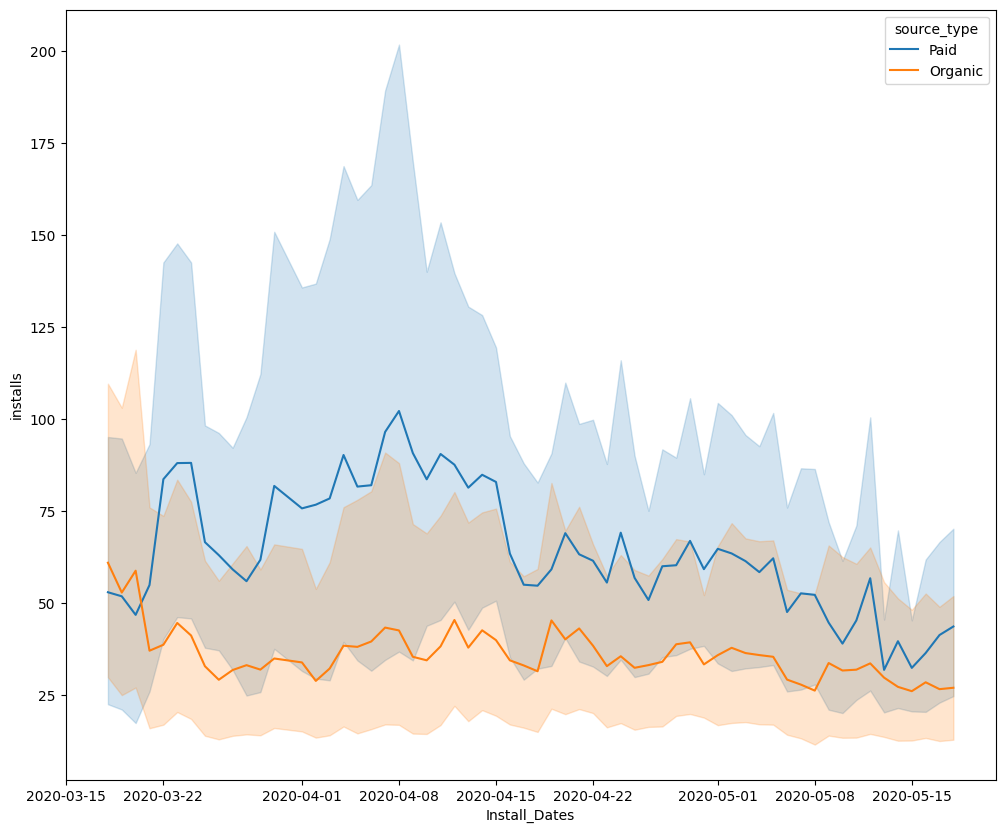

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.lineplot(data=df, x='Install_Dates', y='installs', hue='source_type')
plt.show()

In [29]:
df_grouped = df.groupby(['Install_Dates', 'source_type']).agg({'installs': 'sum'}).reset_index()
df_paid = df_grouped[df_grouped['source_type'] == 'Paid'][['Install_Dates', 'installs']].rename(columns={'installs': 'traffic_paid'})
df_organic = df_grouped[df_grouped['source_type'] == 'Organic'][['Install_Dates', 'installs']].rename(columns={'installs': 'traffic_organic'})
df_merged = pd.merge(df_paid, df_organic, on='Install_Dates', how='outer').fillna(0)

In [26]:
df_merged = df_merged.fillna(0)

In [30]:
df_merged.head()

,Install_Dates,traffic_paid,traffic_organic
0,2020-03-18,7359.0,8961.0
1,2020-03-19,6739.0,8457.0
2,2020-03-20,7254.0,8819.0
3,2020-03-21,9552.0,4485.0
4,2020-03-22,14804.0,5105.0


In [31]:
!pip install pycausalimpact


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
from causalimpact import CausalImpact
data = df_merged[['traffic_organic', 'traffic_paid']]

# кросс-валидация
train_data = data.iloc[:int(0.8 * len(data))]  
test_data = data.iloc[int(0.8 * len(data)):]  
data_combined = pd.concat([train_data, test_data])

ci = CausalImpact(data_combined, pre_period=[0, len(train_data) - 1], post_period=[len(train_data), len(data_combined) - 1])

print(ci.summary())
print(ci.summary(output='report'))

C:\Users\Igor\AppData\Local\Programs\Python\Python310\lib\site-packages\causalimpact\main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
C:\Users\Igor\AppData\Local\Programs\Python\Python310\lib\site-packages\causalimpact\main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
C:\Users\Igor\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: nseasons, standar

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    3635.15            47257.0
Prediction (s.d.)         4826.09 (373.91)   62739.23 (4860.77)
95% CI                    [4095.46, 5561.14] [53240.98, 72294.83]

Absolute effect (s.d.)    -1190.94 (373.91)  -15482.23 (4860.77)
95% CI                    [-1925.99, -460.31][-25037.83, -5983.98]

Relative effect (s.d.)    -24.68% (7.75%)    -24.68% (7.75%)
95% CI                    [-39.91%, -9.54%]  [-39.91%, -9.54%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 3635.15. By contrast, in the absence of an
intervention, we would have expected an average response of 4826.09.
The 95% interval of this counterfactual prediction is [4095.46, 5561.14].
Subtract

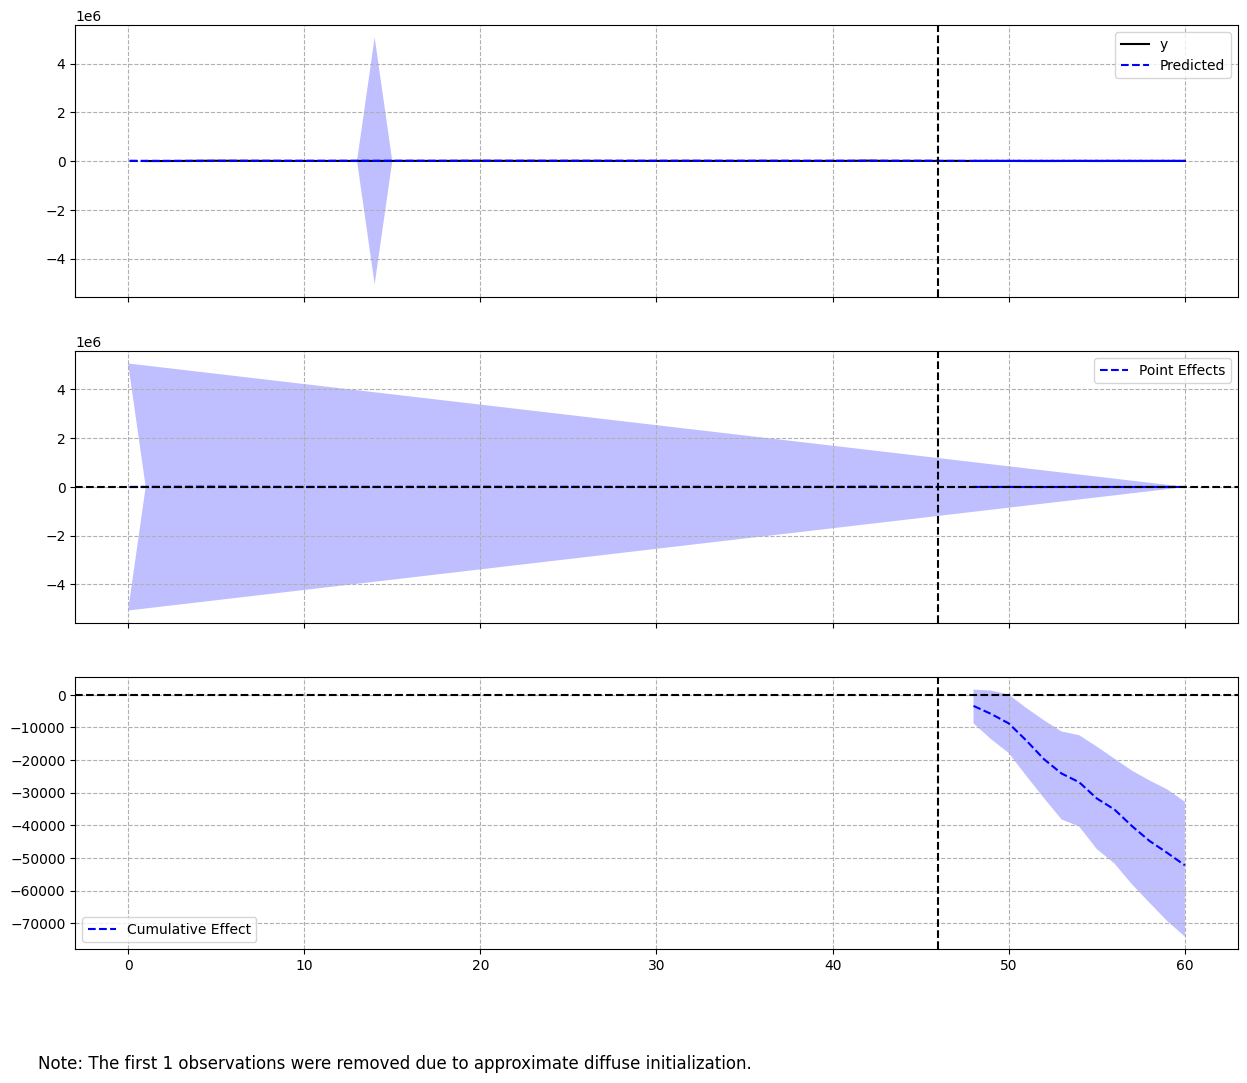

In [34]:
ci.plot()

<p>
    Никогда не использовал CausalImpact в работе. Судя по выводам, которые он сделал, мы можем наблюдать скорее негативный статистически значимый эффект. Это означает, что когда маркетологи приклекают больше рекламного трафика, органический падает. <br>
    Предположу, что влияние рекламного трафика имеет долгосрочный характер. Т.е. игроки сначала заходят в игру сами, играют и только потом привлекают других игроков, тем самым создавая органический трафик.
</p>

<Axes: >

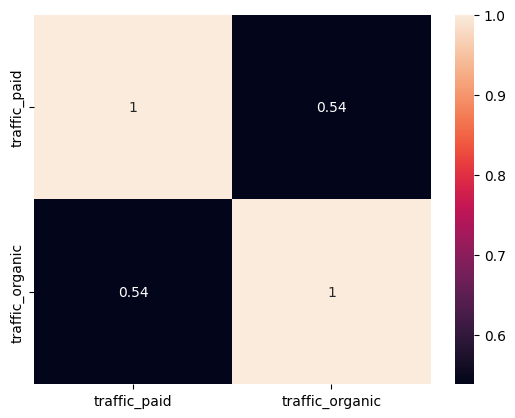

In [48]:
#корреляция конечно не указывает на наличие причинно-следственной связи,
#но посмотреть её стоит
df_merged[['traffic_paid', 'traffic_organic']].corr()
sns.heatmap(df_merged[['traffic_paid', 'traffic_organic']].corr(method='spearman'), annot=True)

In [49]:
end_time = datetime.now()
time_diff = end_time - start_time

print("Конечное время:", end_time)
print("Прошло времени:", time_diff)

Конечное время: 2025-02-09 16:37:34.605801
Прошло времени: 0:39:13.510856


## Время ~ 1.5 часа